In [2]:
from langgraph.graph import StateGraph, START, END

from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from typing import List, Literal

In [3]:
llm = ChatOllama(model="qwen3:4b", temperature=0.6)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage

async def direct(state: MessagesState):
    query = state["messages"][-1].content
    # Use medium temperature LLM for natural direct responses
    # Stream tokens and accumulate the full response
    content_parts = []
    async for chunk in llm.astream([HumanMessage(content=query)]):
        if chunk.content:
            content_parts.append(chunk.content)
    
    # Create final response with accumulated content
    response = AIMessage(content="".join(content_parts))
    return {"messages": [response]}

# Cell 10: Build the Graph (exact translation of graph.ts)
builder = StateGraph(MessagesState)

builder.add_node("direct", direct)

builder.add_edge(START, "direct")
builder.add_edge("direct", END)

graph = builder.compile()

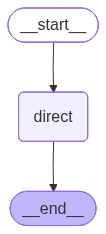

In [5]:
# Cell 11: Visualize Graph (optional)
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available")

In [ ]:
# Should Think - Streaming
print("\n" + "="*60)
print("MODEL THINKING PROCESS")
print("="*60 + "\n")

async for event in graph.astream_events(
    {
        "messages": [HumanMessage(content="Add 2 + 3")],
        # "messages": [HumanMessage(content="You are a clever assistant. A farmer has 17 sheep. All but 9 die. How many sheep are left alive??")],
    },
    version="v2",
):
    event_type = event.get("event", "")
    event_name = event.get("name", "")
    
    # Show graph/node execution start
    if event_type == "on_chain_start":
        if event_name == "LangGraph":
            print("🧠 Starting graph execution...")
        elif event_name == "direct":
            print(f"📝 Executing node: {event_name}")
            metadata = event.get("metadata", {})
            if "langgraph_node" in metadata:
                print(f"   Node: {metadata['langgraph_node']}")
    
    # Show when LLM starts thinking
    elif event_type == "on_chat_model_start":
        print(f"🤔 LLM ({event_name}) starting to think...")
        data = event.get("data", {})
        if "input" in data and "messages" in data["input"]:
            messages = data["input"]["messages"]
            if messages:
                last_msg = messages[-1] if isinstance(messages, list) else messages
                if hasattr(last_msg, "content"):
                    print(f"   Input: {last_msg.content[:100]}...")
    
    # Stream the actual thinking/output tokens
    elif event_type == "on_chat_model_stream":
        chunk = event.get("data", {}).get("chunk")
        if chunk:
            content = None
            if hasattr(chunk, "content"):
                content = chunk.content
            elif isinstance(chunk, dict) and "content" in chunk:
                content = chunk["content"]
            
            if content:
                print(content, end="", flush=True)
    
    # Show when LLM finishes thinking
    elif event_type == "on_chat_model_end":
        print(f"\n✅ LLM finished thinking")

print("\n" + "="*60)
print("THINKING COMPLETE")
print("="*60 + "\n")


MODEL THINKING PROCESS

🧠 Starting graph execution...
📝 Executing node: direct
   Node: direct
🤔 LLM (ChatOllama) starting to think...

INSPECTING CHUNK STRUCTURE:
Chunk type: <class 'langchain_core.messages.ai.AIMessageChunk'>
Chunk attributes: ['additional_kwargs', 'chunk_position', 'construct', 'content', 'content_blocks', 'copy', 'dict', 'from_orm', 'get_lc_namespace', 'id', 'init_server_tool_calls', 'init_tool_calls', 'invalid_tool_calls', 'is_lc_serializable', 'json', 'lc_attributes', 'lc_id', 'lc_secrets', 'model_computed_fields', 'model_config', 'model_construct', 'model_copy', 'model_dump', 'model_dump_json', 'model_extra', 'model_fields', 'model_fields_set', 'model_json_schema', 'model_parametrized_name', 'model_post_init', 'model_rebuild', 'model_validate', 'model_validate_json', 'model_validate_strings', 'name', 'parse_file', 'parse_obj', 'parse_raw', 'pretty_print', 'pretty_repr', 'response_metadata', 'schema', 'schema_json', 'text', 'to_json', 'to_json_not_implemented', 